# Test: Global Explainer Agent

This notebook isolates and tests the `Global Explainer Agent` to ensure:
1. It correctly receives the System Prompt.
2. It correctly uses `InjectedState` (Native LangGraph feature) to access the DataFrame and Model.
3. The tool call determines Global Feature Importance using SHAP.

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from IPython.display import Image, display
from dotenv import load_dotenv
from catboost import CatBoostClassifier

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage

# Add parent dir
sys.path.append('..')
load_dotenv('../.env')

# --- RELOAD MODULES TO PICK UP CHANGES ---
import agent.nodes.global_explainer
import agent.nodes.local_explainer
import agent.graph

from agent.state import XAIState
from agent.nodes.global_explainer import global_explainer_agent, get_global_feature_importance_shap

/Users/haoyuli/Desktop/Master_Semester_2/Agentic_Explainable_AI_PwC/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Load Data (Custom ARFF Loader)
def load_arff_data(file_path):
    data = []
    columns = []
    with open(file_path, 'r') as f:
        data_started = False
        for line in f:
            line = line.strip()
            if not line: continue
            if line.lower().startswith("@attribute"):
                parts = line.split()
                columns.append(parts[1])
            elif line.lower().startswith("@data"):
                data_started = True
                continue
            elif data_started:
                row = [x.strip().strip("'").strip('"') for x in line.split(',')]
                data.append(row)
    return pd.DataFrame(data, columns=columns)

dataset_path = "../datasets/banking_deposit_subscription/dataset"
df = load_arff_data(dataset_path)

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
       pass 

# 2. Load Model
model = CatBoostClassifier()
model.load_model("../notebooks/models/catboost_model.cbm")

print("Loaded Data and Model.")

Loaded Data and Model.


In [3]:
# 3. Build Mini-Graph for Testing
# Using standard ToolNode combined with InjectedState in the tool definition

tools = [get_global_feature_importance_shap]
tool_node = ToolNode(tools)

workflow = StateGraph(XAIState)
workflow.add_node("agent", global_explainer_agent)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", tools_condition)
workflow.add_edge("tools", "agent")

app = workflow.compile()

Running Graph...

--- Final Result ---
human: Show me the global feature importance.
ai: 
tool: I have generated the Global SHAP Summary Plot. It is saved here: `artifacts/shap_summary_44eca0abfb514595ac42583e75dd79c8.png`.
Displaying: artifacts/shap_summary_44eca0abfb514595ac42583e75dd79c8.png


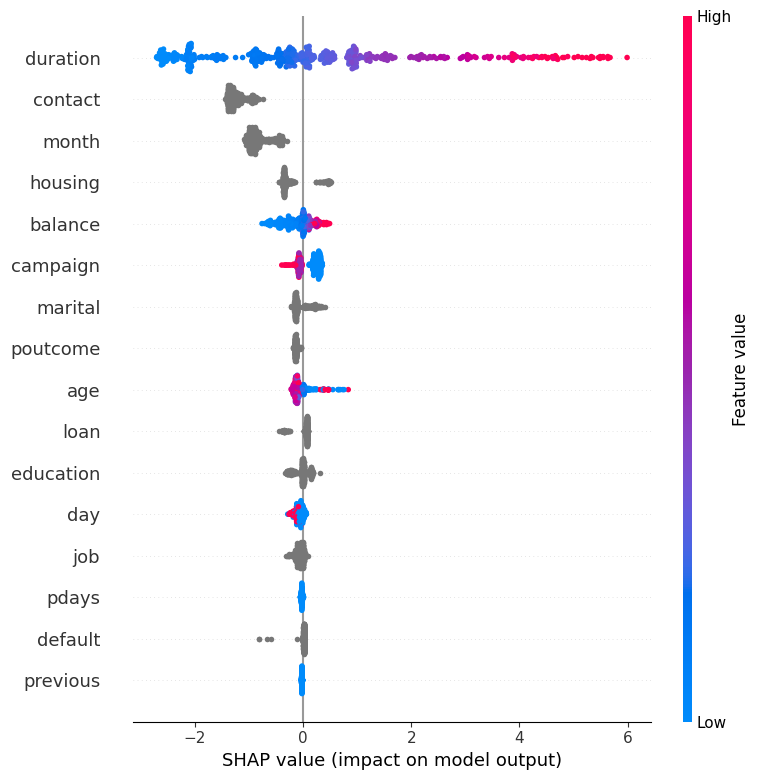

ai: I have generated the Global SHAP Summary Plot for you. You can view it [here](sandbox:/artifacts/shap_summary_44eca0abfb514595ac42583e75dd79c8.png).

In this plot, you will see the features ranked by their importance in the model. The most important features are at the top, and the color represents the feature value (red high, blue low). This visualization helps in understanding which features are driving the predictions and how they are influencing the model's output.


In [4]:
# 4. Run Test Query
initial_state = {
    "messages": [HumanMessage(content="Show me the global feature importance.")],
    "df": df,
    "model": model,
    "target_variable": "y" # Required to drop target from features
}

print("Running Graph...")
result = app.invoke(initial_state)

print("\n--- Final Result ---")
for m in result['messages']:
    print(f"{m.type}: {m.content}")
    
    if "Global SHAP Summary Plot" in m.content and "`" in m.content:
        import re
        paths = re.findall(r'`(.*?)`', m.content)
        for path in paths:
            if path.endswith('.png'):
                print(f"Displaying: {path}")
                display(Image(filename=path))